**Figure 4**. Distribution of PrediXcan core clock gene regulation predictions.<br>
**Figure S2**. Distribution of PrediXcan circadian gene regulation predictions in divergently regulated genes.<br>


In [1]:
# --------------------------------------------------------------
# {'CLOCK': 'ENSG00000134852', 'PER2': 'ENSG00000132326'}

In [18]:
CIRCADIAN_PRED = '../data/predixcan_predictions_circadian.tsv.gz'
CIRCADIAN_GENES = '../data/circadian_genes.list'
TISSUE_MAP = '../data/tissue_name_map.txt'

BASE_URL = 'https://raw.githubusercontent.com/colbrall/neanderthal_predixcan_manuscript/master/data/'
ALTAI_FILE = 'altai_update_pvalues_2sided.txt'
VINDIJA_FILE = 'vindija_pvalues_2sided.txt'
DENISOVA_FILE = 'denisovan_update_pvalues_2sided.txt'

In [9]:
import pandas as pd
import os
import math
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
def p_values(base_url,path):
    # Load archaic p-value files
    url = os.path.join(base_url,path)
    
    archaic = pd.read_csv(url, sep='\t')
    
    archaic = process_pval_dfs(archaic)
    
    return archaic

def process_pval_dfs(df):
    tissue_map = pd.read_csv(TISSUE_MAP, sep='\t',
                      usecols=['GTEx_Tissue','PublishedArchaics_Tissue'])
    
    # Remove extra numbers at the end of each gene id
    df['gene_id'] = df['gene_id'].replace(to_replace ='\.\d+', value ='',regex=True)  
    
    # Intersect with circadian genes
    circadian_genes = pd.read_csv(CIRCADIAN_GENES, sep='\t')['GeneID']
    df = df[df['gene_id'].isin(circadian_genes)]
    
    # Melt
    df = df.melt(id_vars=['gene_id'], var_name='PublishedArchaics_Tissue', value_name='p-value')
    
    # Fix tissue names
    df = pd.merge(tissue_map,df,on='PublishedArchaics_Tissue')
    df.drop(['PublishedArchaics_Tissue'],axis=1,inplace=True)
    
    df.rename(columns={'gene_id':'GeneID'},inplace=True)

    return df


In [30]:
def plot_distribution(df, GeneID, GeneName, Tissue, a_col, h_col, out):
    sns.set(font_scale = 1.4)
    sns.set_style("white")
    
    # Sort by tissue
    df.sort_values(by='GTEx_Tissue',inplace=True)
    
    # Create dictionary containing GeneID:[GeneName,Tissue]
    keys = df[GeneID].values.tolist()
    values = df[[GeneName,Tissue]].values.tolist()
    dictionary = dict(zip(keys, values))
    
    archaic_t = df.iloc[:,[a_col,a_col+1,a_col+2]]
    amh_t = df.iloc[:,h_col:]
    
    #  Categorical Data
    b = 4  # number of rows
    a = math.ceil(len(df)/b)  # number of columns. 
    c = 1  # initialize plot counter

    fig = plt.figure(figsize=(15,15))

    for i in range(len(df)):
        plt.subplot(a, b, c)

        sns.distplot(df.iloc[i:i+1,h_col:], kde=False, color='black', bins=15)
        plt.axvline(df.iloc[i,a_col], color='#c91f97',lw=1.5, alpha=0.8, label='Altai')
        plt.axvline(df.iloc[i,a_col+1], color='#8f59d4',lw=1.5, alpha=0.8, label='Vindija')
        plt.axvline(df.iloc[i,a_col+2], color='#769bce',lw=1.5, alpha=0.8, label='Denisova')
        

        plt.title('{}'.format(values[i][0]))
        #plt.title('{}'.format(dictionary[i][0]))
        plt.xlabel('Imputed regulation \n({})'.format(values[i][1]))
        plt.tight_layout()
        
        c = c + 1

    plt.tight_layout()
    plt.legend(bbox_to_anchor=(1.8, 0.7))
    #plt.savefig(out, dpi=300, bbox_inches='tight')
    plt.show()


In [21]:
# FILES

# Circadian predictions
circadian_pred = pd.read_csv(CIRCADIAN_PRED, sep='\t', compression='gzip')
circadian_genes = pd.read_csv(CIRCADIAN_GENES, sep='\t')

# Add GeneName to circadian_predictions df
circadian_pred = pd.merge(circadian_genes,circadian_pred,left_on='GeneID',right_on='gene')
circadian_pred.drop(['gene'], axis=1, inplace=True)

# P-values
altai_pval = p_values(BASE_URL,ALTAI_FILE)
vindija_pval = p_values(BASE_URL,VINDIJA_FILE)
denisova_pval = p_values(BASE_URL,DENISOVA_FILE)


In [47]:
# ------------------------------------------------------------------------------------------

In [48]:
# PLOT CORE CLOCK GENES

In [85]:
core_clock = [['CLOCK','ENSG00000134852'], ['BMAL1','ENSG00000133794'],
                ['PER1','ENSG00000179094'], ['PER2','ENSG00000132326'], ['PER3','ENSG00000049246'],
                ['CRY1','ENSG00000008405'], ['CRY2','ENSG00000121671'],
                ['NPAS2','ENSG00000170485'],
                ['NR1D1','ENSG00000126368'], ['NR1D2','ENSG00000174738'],
                ['RORA','ENSG00000069667'], ['RORB','ENSG00000198963'], ['RORC','ENSG00000143365'],
                ['DBP','ENSG00000105516'],
                ['CSNK1D','ENSG00000141551'], ['CSNK1E','ENSG00000213923']]
#core_list = list(core_clock.values())
core_df = pd.DataFrame(core_clock,columns=['GeneName','GeneID'])

In [86]:
# Select minimum p-value instance of Gene/Tissue 
min_pvals = altai_pval.loc[altai_pval.groupby('GeneID')['p-value'].idxmin()]

In [87]:
clock_pred = circadian_pred[circadian_pred['GeneID'].isin(core_df['GeneID'])]

In [88]:
clock_pred_min = pd.merge(min_pvals,clock_pred,on=['GeneID','GTEx_Tissue'])

In [89]:
#clock_pred_min.sort_values(by='GTEx_Tissue',inplace=True)

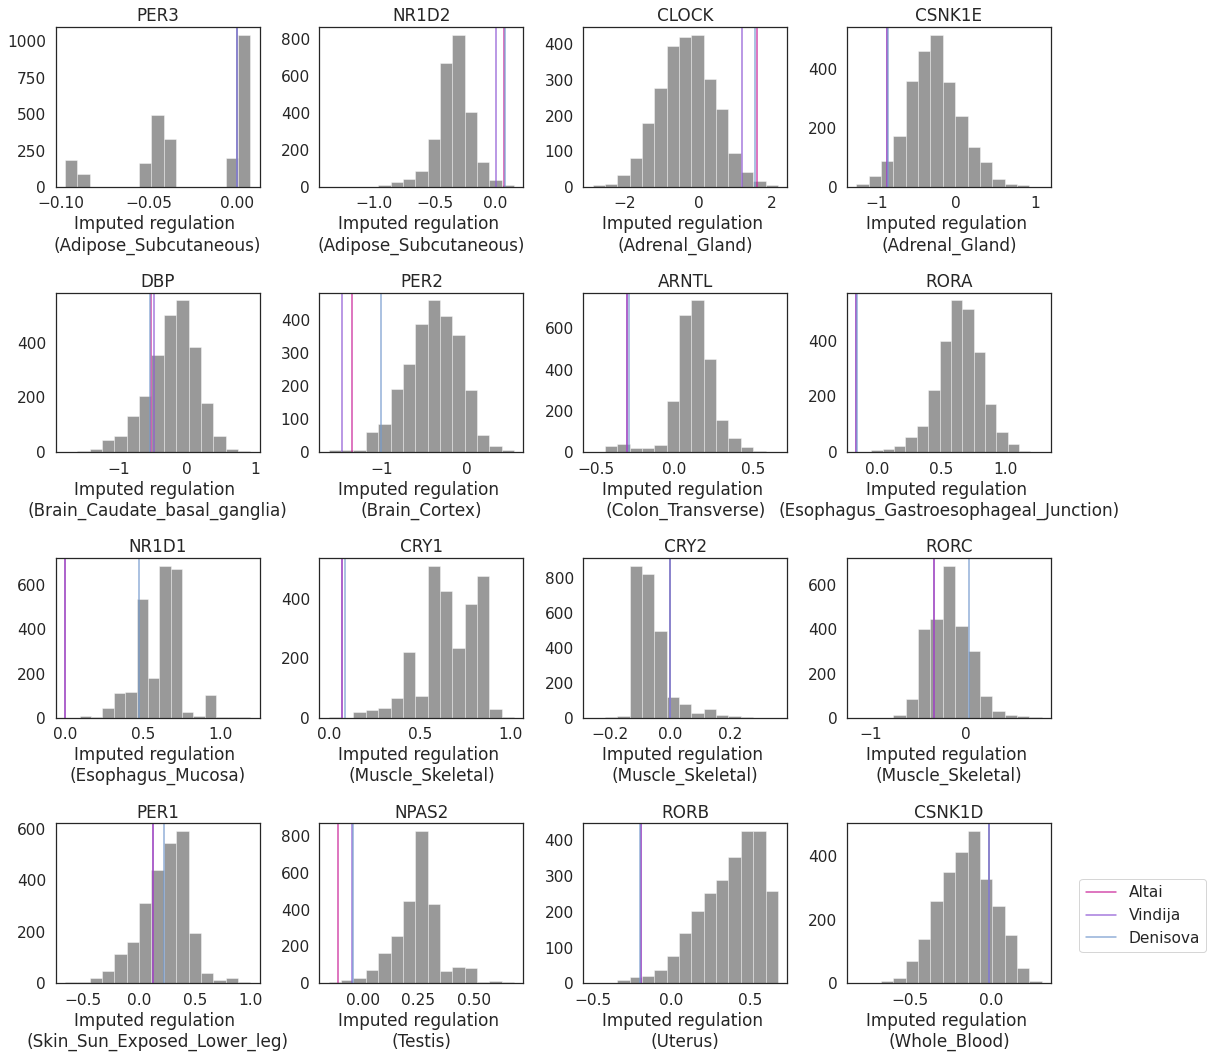

In [94]:
# Plot core Clock genes
plot_distribution(clock_pred_min, 'GeneID','GeneName','GTEx_Tissue',4,7, 
                  'plots/predixcan_dr_clock.pdf')
# displot or histplot

In [81]:
# ------------------------------------------------------------------------------------------

In [82]:
# PLOT DR GENES

In [24]:
# Load list of DR genes
dr_circadian = pd.read_csv('data/predixcan_dr_circadian.txt', sep='\t')

# Extract DR gene predictions from predictions df
dr_circadian_pred = pd.merge(dr_circadian,circadian_pred,on=['GeneID','GeneName','GTEx_Tissue'])
#dr_circadian_pred.to_csv('data/dr_circadian_predictions.tab',index=False,sep='\t')

/opt/anaconda3/envs/py39/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


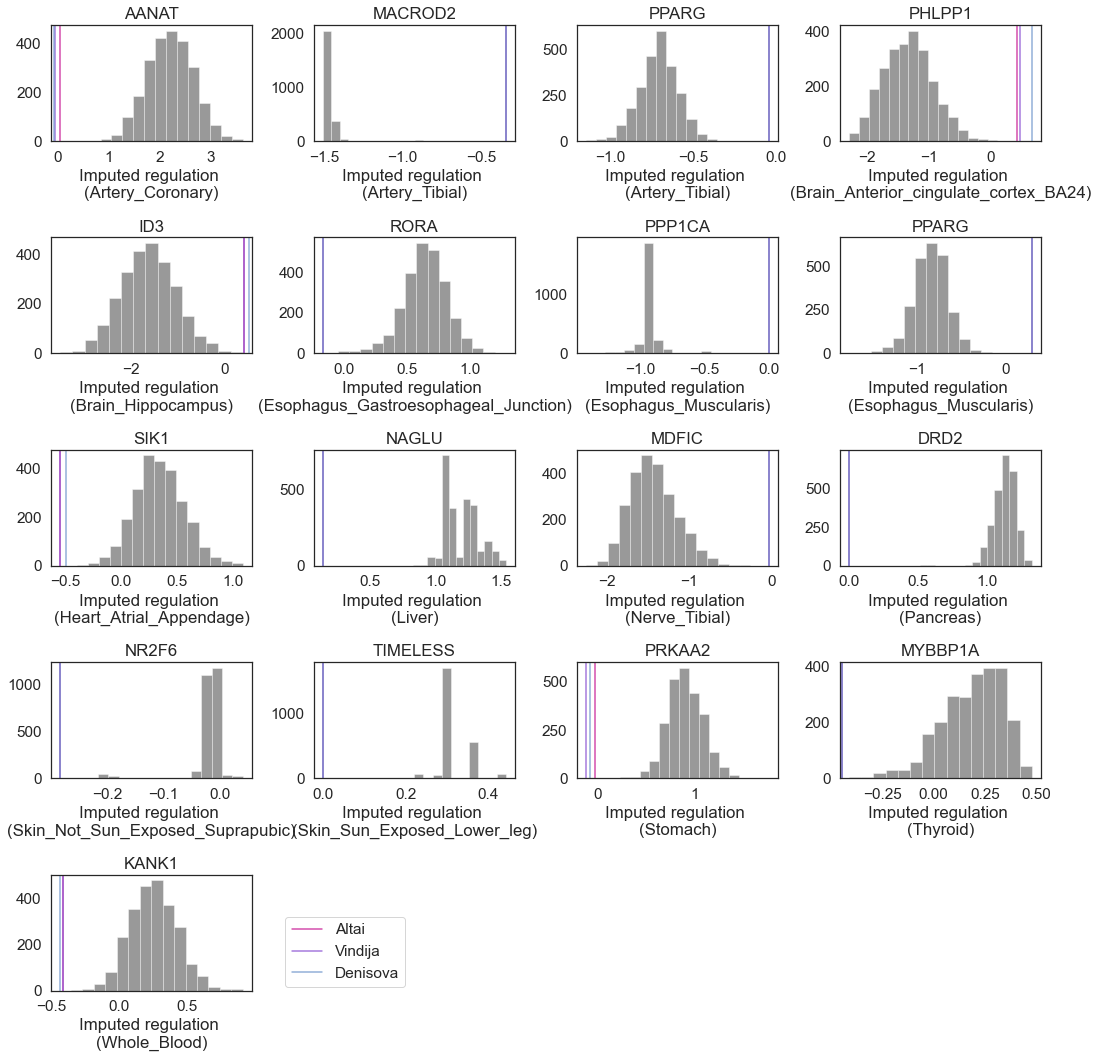

In [31]:
# Plot circadian DR
plot_distribution(dr_circadian_pred,'GeneID','GeneName','GTEx_Tissue',3,6,
                  'plots/predixcan_dr_circadian.pdf')
# displot or histplot